# SGP-Based IPP

In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Import necessary components from sgptools
from sgptools.utils.data import Dataset # Class for loading and managing datasets
from sgptools.utils.misc import get_inducing_pts # Utility for selecting inducing points
from sgptools.utils.tsp import run_tsp # TSP/VRP solver for initial path planning
from sgptools.utils.gpflow import get_model_params # For training initial GP/SGP hyperparameters
from sgptools.methods import ContinuousSGP # The main class for continuous SGP optimization
from sgptools.core.transformations import IPPTransform, SquareTransform # Transforms for IPP and sensor models

# Set random seeds for reproducibility
np.random.seed(1234)
tf.random.set_seed(1234)

2025-06-26 19:46:18.209721: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 19:46:18.213080: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 19:46:18.222306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750985178.240024   46988 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750985178.244371   46988 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750985178.259090   46988 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# --- Helper Functions ---
# These functions encapsulate data loading and plotting logic

def get_dataset():
    """
    Loads and preprocesses a synthetic elevation dataset using the Dataset class.
    
    Returns:
        tuple: (X_train, y_train, X_test, y_test, candidates, 
                X_full_original, y_full_original, X_scaler)
                - X_train (np.ndarray): Normalized training input features.
                - y_train (np.ndarray): Standardized training labels.
                - X_test (np.ndarray): Normalized testing input features.
                - y_test (np.ndarray): Standardized testing labels.
                - candidates (np.ndarray): Normalized candidate locations for sensor placement.
                - X_full_original (np.ndarray): Original (pixel) coordinates of the full dataset.
                - y_full_original (np.ndarray): Original (unscaled) values of the full dataset.
                - X_scaler (sklearn.preprocessing.StandardScaler): Scaler used for X coordinates,
                                                                   needed to inverse transform for plotting.
    """
    # Initialize Dataset to generate synthetic data
    # verbose=False to suppress detailed output during dataset creation
    dataset = Dataset(shape=(1000, 1000), 
                      num_train=1000, 
                      num_test=2500, 
                      num_candidates=150, 
                      verbose=False)
    
    X_train, y_train = dataset.get_train()
    X_test, y_test = dataset.get_test()
    candidates = dataset.get_candidates()
    
    # Get original (unscaled) X and y for the entire dataset for ground truth visualization.
    # The `dataset.y` holds the *standardized* full dataset.
    # We inverse transform it and its mask to get original values and coordinates.
    y_full_unscaled = dataset.y_scaler.inverse_transform(dataset.y.reshape(-1,1)).reshape(dataset.y.shape)
    mask = np.where(np.isfinite(y_full_unscaled))
    
    # X_full_original represents the pixel coordinates (col, row)
    X_full_original = np.column_stack((mask[1], mask[0])) 
    y_full_original = y_full_unscaled[mask].reshape(-1, 1)

    return X_train, y_train, X_test, y_test, candidates, X_full_original, y_full_original, dataset.X_scaler

def plot_paths(paths, X_ground_truth_original, y_ground_truth_original, X_scaler, title, candidates=None, expanded_points=None):
    """
    Plots the ground truth data, candidate locations, and optimized paths.
    All coordinates are inverse-transformed to the original pixel space for visualization.

    Args:
        paths (np.ndarray): (num_robots, num_placements, num_dim); Optimized paths in normalized space.
        candidates (np.ndarray): (num_candidates, num_dim); Candidate locations in normalized space.
        X_ground_truth_original (np.ndarray): Original pixel coordinates of the full ground truth data.
        y_ground_truth_original (np.ndarray): Original (unscaled) values of the full ground truth data.
        X_scaler (sklearn.preprocessing.StandardScaler): Scaler used for X coordinates,
                                                         to inverse transform paths and candidates.
        title (str): Title for the plot.
        expanded_points (np.ndarray, optional): Additional points (e.g., expanded FoV points) to plot,
                                                also in normalized space. Defaults to None.
    """
    plt.figure()
    # Plot ground truth data as background, in original pixel coordinates
    plt.scatter(X_ground_truth_original[:, 0], X_ground_truth_original[:, 1], c=y_ground_truth_original, cmap='jet', alpha=0.5)

    # Inverse transform candidates to original pixel coordinates for plotting
    if candidates is not None:
        candidates_original = X_scaler.inverse_transform(candidates)
        plt.scatter(candidates_original[:, 0], candidates_original[:, 1], s=10, c='k', marker='x', label='Candidates')
    
    colors = ['r', 'g', 'b', 'c', 'm', 'y'] # Colors for different robot paths
    
    for i, path in enumerate(paths):
        # Inverse transform each robot's path to original pixel coordinates
        path_original = X_scaler.inverse_transform(path)
        plt.plot(path_original[:, 0], path_original[:, 1], 'o-', color=colors[i % len(colors)], label=f'Optimized Path {i+1}')

    if expanded_points is not None:
        # Inverse transform expanded FoV points if provided
        expanded_points_original = X_scaler.inverse_transform(expanded_points)
        plt.scatter(expanded_points_original[:, 0], expanded_points_original[:, 1], s=10, c='purple', alpha=0.3, label='Expanded FoV Points') # Use a distinct color for clarity

    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.gca().set_aspect('equal', adjustable='box') # Maintain aspect ratio
    plt.legend()
    plt.show()


## Get the data and initial SGP hyperparameters


2025-06-26 19:46:27.427826: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.56987931799591      │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [1.95709 1.92742]     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.006228

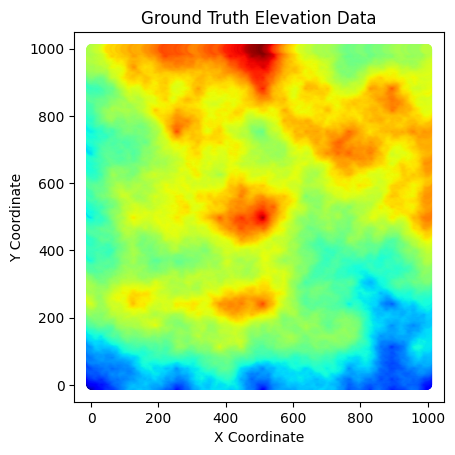

In [3]:
print("## Get the data and initial SGP hyperparameters")

# Get the synthetic elevation data and scalers
X_train, y_train, X_test, y_test, candidates, X_ground_truth_original, y_ground_truth_original, X_scaler = get_dataset()

# Train a Gaussian Process (GP) model and get the optimized kernel parameters
# `get_model_params` returns loss_values, noise_variance, kernel_object
_, noise_variance, kernel = get_model_params(X_train, y_train, 
                                             lengthscales=[1.0, 1.0], # Initial lengthscales for the RBF kernel
                                             optimizer='scipy.L-BFGS-B') # Use SciPy's L-BFGS-B optimizer

# Plot the ground truth data
plt.figure()
plt.scatter(X_ground_truth_original[:, 0], X_ground_truth_original[:, 1], c=y_ground_truth_original, cmap='jet', alpha=0.8)
plt.title("Ground Truth Elevation Data")
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## Single-Robot IPP with Point Sensing


/home/itskalvik/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


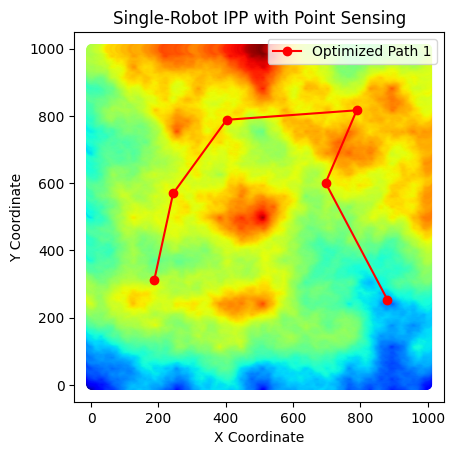

In [4]:
print("\n## Single-Robot IPP with Point Sensing")

num_robots = 1
num_placements = 6 # Number of sensing locations (waypoints) for the robot

# Initialize inducing points (initial path waypoints) using k-means from training data.
# Then, solve a Traveling Salesperson Problem (TSP) to get a coherent initial path.
Xu_init = get_inducing_pts(X_train, num_placements * num_robots)
# run_tsp returns a list of paths and distances. For single robot, take the first path.
Xu_init, _ = run_tsp(Xu_init, num_vehicles=num_robots)
Xu_init = Xu_init[0] # Initial path for the single robot

# Setup the IPP transform for point sensing (sampling_rate=2 is default for point sensing)
transform_point_sensing = IPPTransform(num_robots=num_robots, num_dim=2)

# Initialize the ContinuousSGP optimizer
# Parameters: num_sensing, X_objective, kernel, noise_variance, transform, num_robots, X_init
csgp_method_point_sensing = ContinuousSGP(
    num_placements, 
    X_train, # X_train serves as the X_objective for the SGP model
    kernel,
    noise_variance, 
    transform_point_sensing,
    num_robots,
    X_init=Xu_init
)

# Optimize the inducing points (path waypoints)
sgp_paths_point_sensing = csgp_method_point_sensing.optimize(max_steps=1000)

# Plot the solution
plot_paths(sgp_paths_point_sensing, X_ground_truth_original, y_ground_truth_original, X_scaler,
           title="Single-Robot IPP with Point Sensing")


## Single-Robot IPP with Continuous Sensing


/home/itskalvik/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


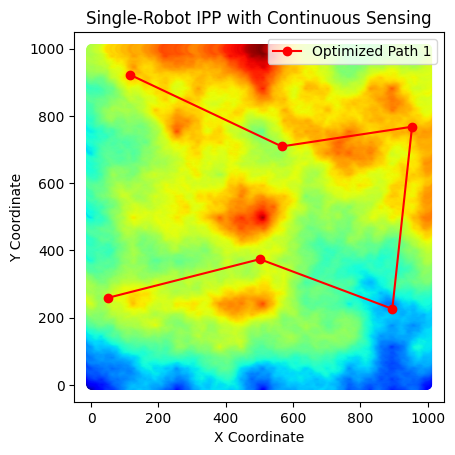

In [5]:
print("\n## Single-Robot IPP with Continuous Sensing")

num_robots = 1
num_placements = 6

# Initialize inducing points and get initial path as before
Xu_init_continuous = get_inducing_pts(X_train, num_placements * num_robots)
Xu_init_continuous, _ = run_tsp(Xu_init_continuous, num_vehicles=num_robots)
Xu_init_continuous = Xu_init_continuous[0]

# Setup IPP transform with a higher sampling rate for continuous sensing
transform_continuous_sensing = IPPTransform(num_robots=num_robots,
                                            num_dim=2,
                                            sampling_rate=5) # Sample 5 points between each waypoint

# Initialize and optimize the ContinuousSGP model
csgp_method_continuous_sensing = ContinuousSGP(
    num_placements, 
    X_train, 
    kernel,
    noise_variance, 
    transform_continuous_sensing,
    num_robots,
    X_init=Xu_init_continuous
)
sgp_paths_continuous_sensing = csgp_method_continuous_sensing.optimize(max_steps=1000)

# Plot the solution
plot_paths(sgp_paths_continuous_sensing, X_ground_truth_original, y_ground_truth_original, X_scaler,
           title="Single-Robot IPP with Continuous Sensing")


## Single-Robot IPP with Continuous Non-point FoV Sensor


/home/itskalvik/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


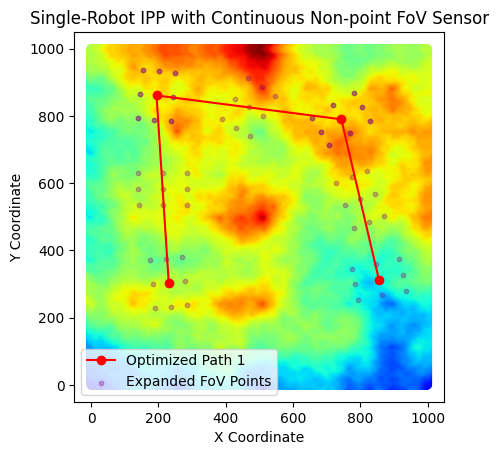

In [6]:
print("\n## Single-Robot IPP with Continuous Non-point FoV Sensor")

num_robots = 1
num_placements = 4 # Fewer placements as each covers an area

# Initialize inducing points, including an initial random angle for each FoV
Xu_init_fov = get_inducing_pts(X_train, num_placements * num_robots)
Xu_init_fov, _ = run_tsp(Xu_init_fov, num_vehicles=num_robots)
Xu_init_fov = Xu_init_fov[0] # Path for the single robot

# Add random angles (orientation of FoV) to inducing points (waypoints)
# For a 2D position (x, y), we add a 3rd dimension for angle.
angles = np.random.uniform(-np.pi, np.pi, num_placements).reshape(-1, 1)
Xu_init_fov_with_angles = np.concatenate([Xu_init_fov, angles], axis=1)

# Setup a SquareTransform to model a square Field of View (FoV) for the sensor.
# `length` is the side length of the square, `num_side` is points along each side (3x3 grid for FoV approx).
square_transform = SquareTransform(length=5, num_side=3)

# Setup IPP transform with the custom sensor model and continuous sensing.
# num_dim=3 because the inducing points now have (x, y, angle) dimensions.
transform_fov_sensing = IPPTransform(num_robots=num_robots,
                                     num_dim=3, # Input to transform has 3 dimensions (x, y, angle)
                                     sampling_rate=3, # Continuous sensing along path segments
                                     sensor_model=square_transform) # The custom FoV model

# Initialize and optimize the ContinuousSGP model
csgp_method_fov_sensing = ContinuousSGP(
    num_placements, 
    X_train, 
    kernel,
    noise_variance,
    transform_fov_sensing,
    num_robots,
    X_init=Xu_init_fov_with_angles, # Initial points now include angles
    num_dim=3 # Explicitly mention number of dimensions (x, y, angle) since it is different from X_train dim
)
sgp_sol_sp_fov_sensing = csgp_method_fov_sensing.optimize(max_steps=1000)

# Extract just the (x,y) coordinates of the path for plotting
sgp_paths_fov_sensing = sgp_sol_sp_fov_sensing[:, :, :2].reshape(num_robots, -1 , 2)

# Expand the optimized inducing points using the transform's expand method
# to get all the individual points making up the FoVs for plotting.
# Need to convert back to TF tensor for the transform.expand method.
expanded_fov_points = csgp_method_fov_sensing.transform.expand(sgp_sol_sp_fov_sensing).numpy()

# Plot the solution path and the FoVs
plot_paths(sgp_paths_fov_sensing[:, :, :2], X_ground_truth_original, y_ground_truth_original, X_scaler,
           title="Single-Robot IPP with Continuous Non-point FoV Sensor", 
           expanded_points=expanded_fov_points)


## Multi-Robot IPP with Continuous Sensing and a Distance Budget


/home/itskalvik/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


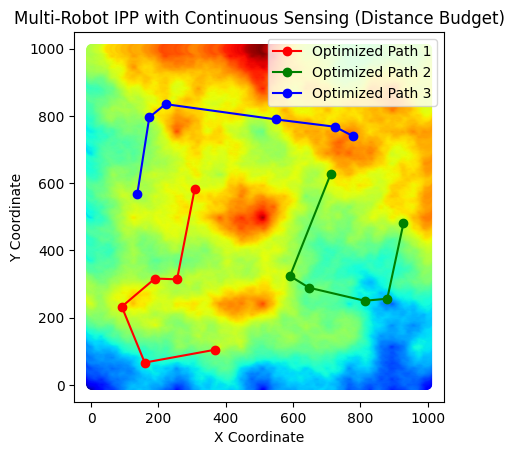

Distances (Normalized Units): [29.9997547  30.         30.00014232]


In [7]:
print("\n## Multi-Robot IPP with Continuous Sensing and a Distance Budget")

num_robots = 3
num_placements = 6 # Waypoints per robot

# Initialize inducing points for multiple robots
Xu_init_multi_robot = get_inducing_pts(X_train, num_placements * num_robots)

# Run TSP/VRP for multiple vehicles, with a max_dist constraint and resampling
Xu_init_multi_robot, _ = run_tsp(Xu_init_multi_robot, 
                                 num_vehicles=num_robots,
                                 max_dist=100, # Initial max distance budget for TSP
                                 resample=num_placements) # Ensure each path has num_placements waypoints
Xu_init_multi_robot = Xu_init_multi_robot.reshape(-1, 2) # Flatten paths into a single array of waypoints

# Setup distance-constrained IPP transform for multiple robots
transform_multi_robot = IPPTransform(num_robots=num_robots,
                                     num_dim=2,
                                     sampling_rate=5, # Continuous sensing
                                     distance_budget=30., # Strict distance budget for each robot
                                     constraint_weight=500.) # Weight for the distance constraint in optimization

# Initialize and optimize the ContinuousSGP model for multi-robot scenario
csgp_method_multi_robot = ContinuousSGP(
    num_placements, 
    X_train, 
    kernel,
    noise_variance, 
    transform_multi_robot,
    num_robots,
    X_init=Xu_init_multi_robot
)
sol_paths_multi_robot = csgp_method_multi_robot.optimize(max_steps=5000) # More steps for complex multi-robot optimization

# Plot the optimized paths
plot_paths(sol_paths_multi_robot, X_ground_truth_original, y_ground_truth_original, X_scaler,
           title="Multi-Robot IPP with Continuous Sensing (Distance Budget)")

# Print the final distances for each optimized path
# The transform.distance method calculates the total path length based on the current inducing points
print("Distances (Normalized Units):", transform_multi_robot.distance(tf.constant(sol_paths_multi_robot, dtype=tf.float64)).numpy())